<a href="https://colab.research.google.com/github/kozen88/ProgettoIcon2023/blob/main/Ensemble_learning_model_WORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble learning
L'ensemble learning risulta essere un ottimo approccio per affrontare dataset sbilanciati e cercare di apprendere al meglio il concetto che si voglia la macchina apprenda, per tali ragioni andremo ad addestrare un modello di ensemble e ottimizzarlo.

ricordiamo che le tecniche di ensemble si dividono in:
- Baggging
- Boosting
- Stacking

Ogniuna presenta caratteristiche e peculiarità di apprendimento differenti, per lo studio iniziamo scegliendo la tecnica di Bagging che sta per Boostrap Agregating l'idea è addestrare più classificatore su differenti training set creati tutti a partire dai nostri dati di partenza per mezzo di un processo di campionamento randomico con reinserimento degli esempi selezionati per un campione. Alla fine i modelli addestrati produrranno delle predizioni le quali saranno aggregate tramite una funzione di aggregazionne nella predizione finale.

Scegliamo come modello enemble basto su bagging il
- Random Forest

In [1]:
from ast import increment_lineno
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import precision_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df_impiegati = pd.read_excel('Data_set_impiegati_one_hot_enc.xlsx')

In [ ]:
df_impiegati

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_human_resources,department_management,department_marketing,department_product_mng,department_sales,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14997,0.11,0.96,6,280,4,0,1,0,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
csv_file = 'Data_set_impiegati_one_hot_enc.csv'
df_impiegati.to_csv(csv_file, index=False)

In [3]:
X = df_impiegati.drop('left', axis=1)
y = df_impiegati['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train, y_test = y_train.values, y_test.values
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (11249, 18)
X_test shape:  (3750, 18)
y_train.shape:  (11249,)
y_test shape:  (3750,)


In [4]:
# Instanziamo un modello Random forest e andiamo ad addestrarlo con hold out
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [5]:
print("_______________RANDOM FOREST PERFORMANCE________________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_rf))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_rf))

_______________RANDOM FOREST PERFORMANCE________________
------------------------Accuracy------------------------

0.9890666666666666

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2853
           1       0.99      0.96      0.98       897

    accuracy                           0.99      3750
   macro avg       0.99      0.98      0.98      3750
weighted avg       0.99      0.99      0.99      3750



In [6]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', fontsize=22, title_color='#660000'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Calcola le percentuali
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='OrRd')  # Utilizza fmt=".2%" per visualizzare le percentuali con due decimali
    plt.title(title, fontsize=fontsize, color=title_color)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

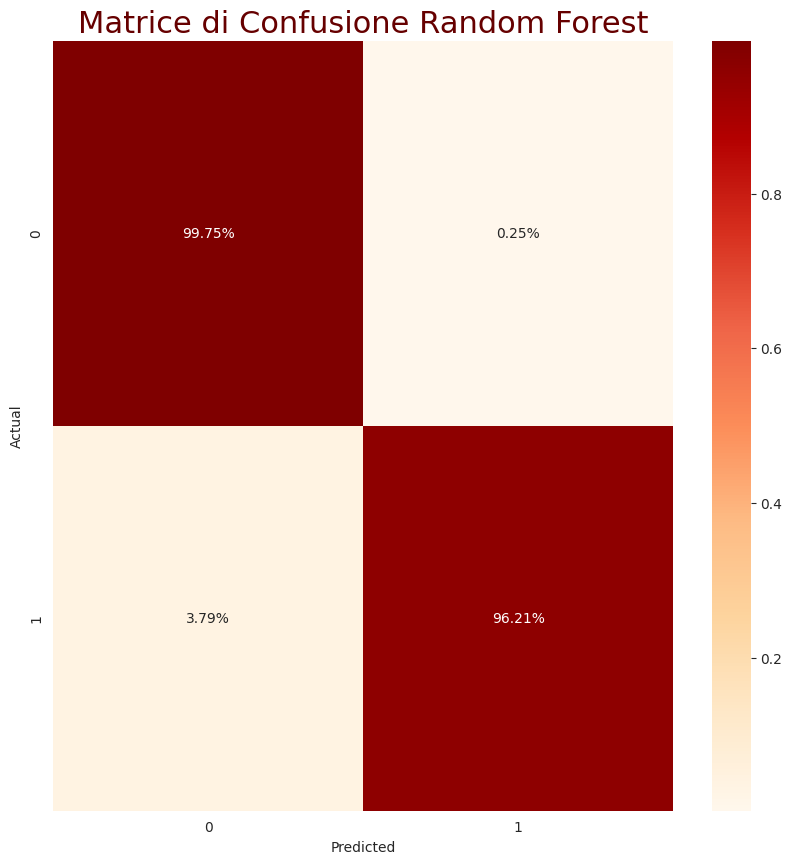

In [ ]:
plot_confusion_matrix(y_test, pred_rf, title='Matrice di Confusione Random Forest', fontsize=22, title_color='#660000')

In [ ]:
random_forest_cv_score = cross_val_score(RandomForestClassifier(), X, y, cv=8, scoring='recall')
print("Random Forest Cross Validation Recall scores are: {}".format(random_forest_cv_score ))
print("Random Forest Average Cross Validation Recall score: {}".format(random_forest_cv_score.mean()))

## Fine addestramento di base Random Forest
Dopo aver addestrato un modello di ensemble learning i risultati sono stati ottimi a fronte di un addestramento base senza ottimizzazione degli iperparametri nè di un processo di cross validation stratificata infatti il solo hold out è stato sufficiente a superare di gran lunga i risultati ottenuti con i Gaussian Naive Bayes e con la Logist Regression. Nonostatne gli ottimi risultati sorge il sospetto che il dataset non sia contenetne dati provenienti da un ambiente di lavoro reale dato che riuscire ad avere i risultati che abbiamo ottenuto sembra alquanto irrealistico dato che sono ottimi.

## Continuiamo la sperimentazione sui modelli di ensemble
Adesso andremo ad addestrare un modello di ensemble basato su stacking. Questa tecnica è molto differente dalla precedente primo perchè utilizza più learner di base da cui andrà ad estrarre la predizione finale. L'idea alla base è quella di andare ad addestrare indipendentemente un numero di classificatori di base alla fine del loro addestramento le loro predizioni saranno combinate tramite una funzione aggregate tale funzione aggregante sarà appresa dal meta-learner un modello finale atta a combinare le predizioni dei modelli di base per fornire la predizione finale.

In [7]:
# Definisci i classificatori base che fornirranno la pila di modelli
base_classifiers = [
    ('decTree', DecisionTreeClassifier()),
    ('gaussiaNB', GaussianNB()),
    ('svm', SVC())
]

# Andiamo a creare il modello di stacking a partire da quelli di base e dal meta-learner
# che sarà il final_classifier
final_classifier = LogisticRegression()
stacking_classifier = StackingClassifier(estimators=base_classifiers, final_estimator=final_classifier)

# Addestra il classificatore di stacking
stacking_classifier.fit(X_train, y_train)
pred_stacking = stacking_classifier.predict(X_test)

In [8]:
print("_______________STACKING MODEL PERFORMANCE________________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_stacking))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_stacking))

_______________STACKING MODEL PERFORMANCE________________
------------------------Accuracy------------------------

0.9714666666666667

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2853
           1       0.92      0.96      0.94       897

    accuracy                           0.97      3750
   macro avg       0.95      0.97      0.96      3750
weighted avg       0.97      0.97      0.97      3750



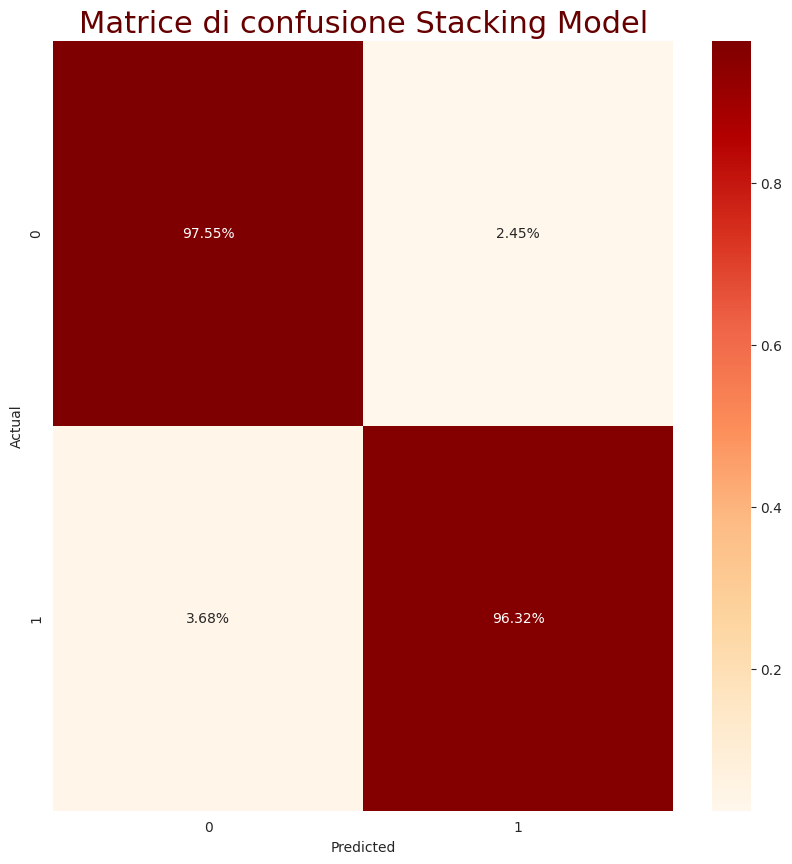

In [ ]:
plot_confusion_matrix(y_test, pred_stacking, title='Matrice di confusione Stacking Model', fontsize=22, title_color='#660000')

In [ ]:
stacking__cv_score = cross_val_score(StackingClassifier(estimators=base_classifiers, final_estimator=final_classifier), X, y, cv=5, scoring='recall')
print("Stacking Cross Validation Recall scores are: {}".format(stacking__cv_score))
print("Stacking Average Cross Validation Recall score: {}".format(stacking__cv_score.mean()))

Abbiamo terminato l'addestramento base di un modello di ensemble basato su stacking, anche questo ha portato a risultati di enorme differenza anche se non è risultato quasi perfetto come lo è stato il Random Forest.

## Ensemble model basati su Boosting


In [9]:
# Definisci il classificatore base (un DecisionTreeClassifier)
base_classifier = DecisionTreeClassifier(max_depth=5)
adaboost_classifier = AdaBoostClassifier(estimator=base_classifier, n_estimators=50, random_state=42)

# Addestra il classificatore AdaBoost
adaboost_classifier.fit(X_train, y_train)
pred_adaboost = adaboost_classifier.predict(X_test)

In [10]:
print("__________________ADABOOST PERFORMANCE__________________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_adaboost))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_adaboost))

__________________ADABOOST PERFORMANCE__________________
------------------------Accuracy------------------------

0.9853333333333333

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2853
           1       0.97      0.97      0.97       897

    accuracy                           0.99      3750
   macro avg       0.98      0.98      0.98      3750
weighted avg       0.99      0.99      0.99      3750



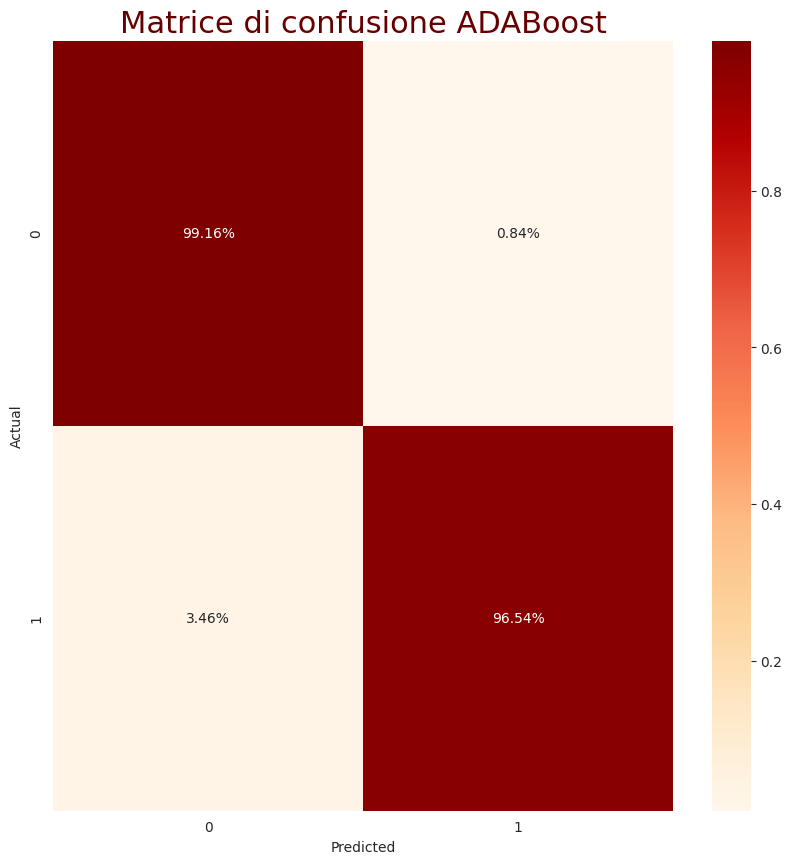

In [ ]:
plot_confusion_matrix(y_test, pred_adaboost, title='Matrice di confusione ADABoost', fontsize=22, title_color='#660000')

In [ ]:
adaboost__cv_score = cross_val_score(AdaBoostClassifier(), X, y, cv=5, scoring='recall')
print("AdaBoost Cross Validation Recall scores are: {}".format(adaboost__cv_score))
print("AdaBoost Average Cross Validation Recall score: {}".format(adaboost__cv_score.mean()))

L'ultimo modello di ensemble l'ADAboost sembra eccellere nell'addestramento proprio come ha fatto il Random forest.

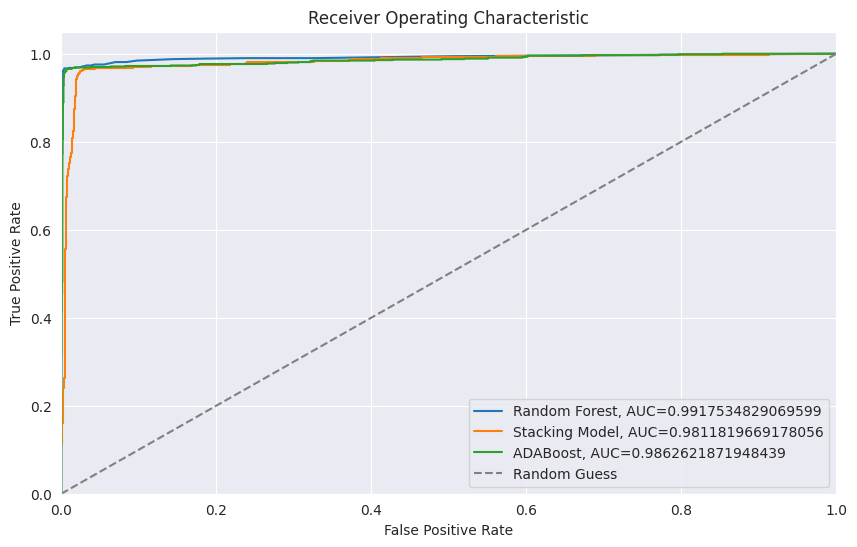

In [ ]:
# Calcola i punteggi delle probabilità positive
pred_RF_positive = rf.predict_proba(X_test)[:, 1]
pred_SM_positive = stacking_classifier.predict_proba(X_test)[:, 1]
pred_AB_positive = adaboost_classifier.predict_proba(X_test)[:, 1]

# Calcola le curve ROC e gli AUC
fpr_RF, tpr_RF, _ = roc_curve(y_test, pred_RF_positive)
auc_RF = roc_auc_score(y_test, pred_RF_positive)

fpr_SM, tpr_SM, _ = roc_curve(y_test, pred_SM_positive)
auc_SM = roc_auc_score(y_test, pred_SM_positive)

fpr_AB, tpr_AB, _ = roc_curve(y_test, pred_AB_positive)
auc_AB = roc_auc_score(y_test, pred_AB_positive)

# Crea il grafico ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_RF, tpr_RF, label="Random Forest, AUC=" + str(auc_RF))
plt.plot(fpr_SM, tpr_SM, label="Stacking Model, AUC=" + str(auc_SM))
plt.plot(fpr_AB, tpr_AB, label="ADABoost, AUC=" + str(auc_AB))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


## Sperimentazione sugli ensemble model

In [ ]:
# la funzione eseguirà l'addestramento del modello usato una cross validartion stratificata
# e andra a plottare un grafico che mostrerà i risultati dell'addestramento in base ad una
# metrica che si vuole massimizzare
# occhio questa funzione necessita di array numpy e non di data frame!!!!!!!
def kfold_crossval_plot(X, y, model, metric_function, metric_name, k_range):

    metric_scores = []
    num_folds_used = []

    for k in k_range:
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        fold_metrics = []

        for train_index, val_index in kf.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            metric = metric_function(y_val, y_pred)

            fold_metrics.append(metric)

        avg_metric = np.mean(fold_metrics)
        metric_scores.append(avg_metric)
        num_folds_used.append(k)

    plt.figure(figsize=(10, 6))
    plt.plot(num_folds_used, metric_scores, marker='o')
    plt.xlabel("Numero di Folds (k)")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} in Base al Numero di Folds (k)")
    plt.grid(True)
    plt.show()

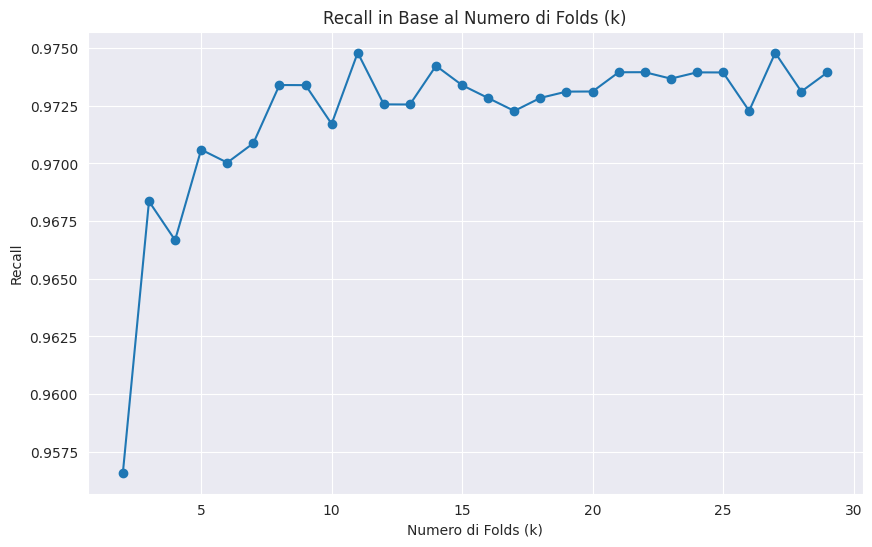

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
X_array = X.values
y_array = y.values
kfold_crossval_plot(X_array, y_array, random_forest, recall_score, "Recall", range(2,30))

In [ ]:
X_array = X.values
y_array = y.values

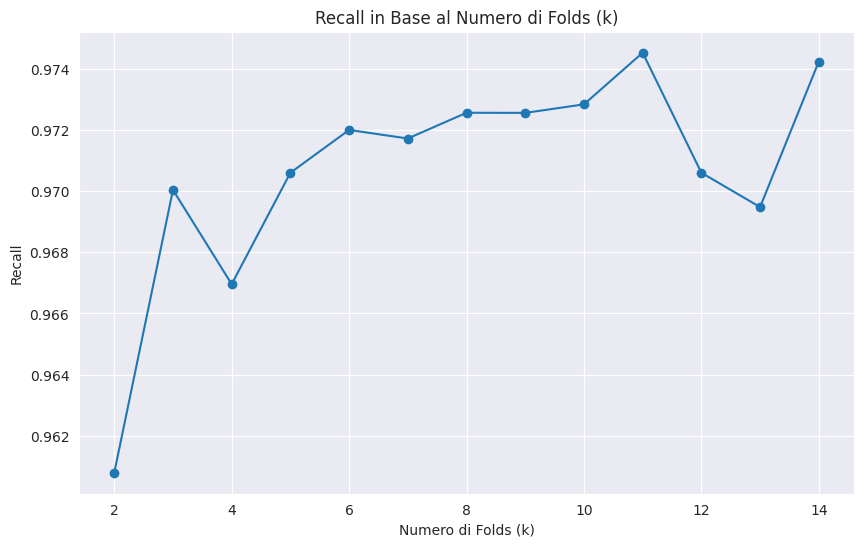

In [ ]:
#Andiamo a valutare il modello di stacking sul numero del CV in modo incrementale

base_classifiers_1 = [
    ('decTree', DecisionTreeClassifier()),
    ('gaussiaNB', GaussianNB()),
    ('svm', SVC())
]
final_classifier_1 = LogisticRegression()
stacking_classifier_1 = StackingClassifier(estimators=base_classifiers_1 , final_estimator=final_classifier_1)

kfold_crossval_plot(X_array, y_array, stacking_classifier_1, recall_score, "Recall", range(2,15))


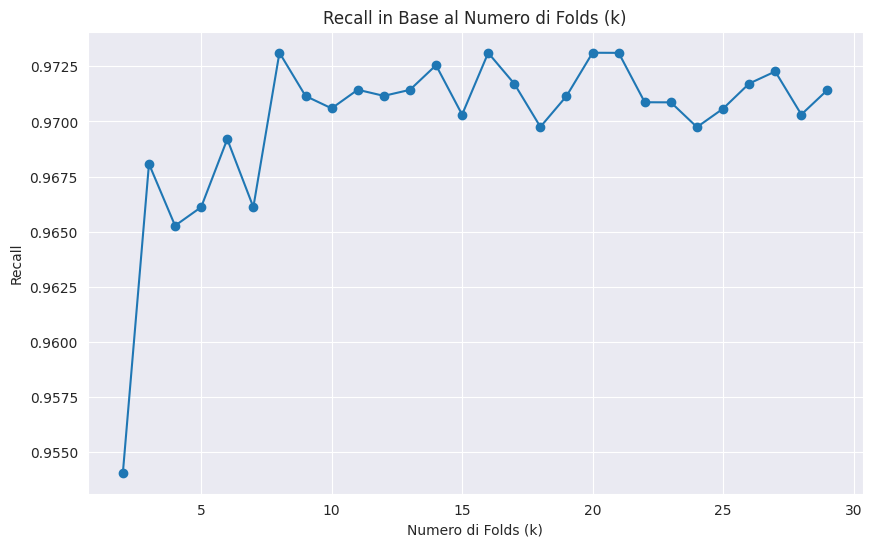

In [ ]:
adaboost_c = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=42)
kfold_crossval_plot(X_array, y_array, adaboost_c, recall_score, "Recall", range(2,30))

## OTTIMIZZAZIONE DEI PARAMETRI DEI MODELLI
Proviamo ad ottimizzare i modelli precedentemente addestrati e effettuare una cross validation dei modelli finali ottimizzati con il migliore fold per gli split della cross validation

Ottimizzazione dell'AdaBoost

In [ ]:
parametri_adaboost = {
    'n_estimators': [25, 50, 75, 100],           # Numero di stimatori (alberi)
    'learning_rate': [0.01, 0.1, 0.5, 1.0],       # Tasso di apprendimento
    'algorithm': ['SAMME', 'SAMME.R'],           # Algoritmo utilizzato
    'loss': ['linear', 'square', 'exponential'],  # Tipo di funzione di perdita da minimizzare
    'random_state': [30]
}

In [ ]:
# Crea un oggetto GridSearchCV
grid_search_adaboost = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=parametri_adaboost, cv=8, scoring='recall')

# Addestra il modello
grid_search_adaboost.fit(X_train, y_train)

# Ottieni i parametri migliori
best_params_adaboost = grid_search_adaboost.best_params_
best_score_adaboost_grids = grid_search_adaboost.best_score_
print('Best parameters:',best_params_adaboost)
print('Best score:', best_score_adaboost_grids)

In [ ]:
adaboost_best_param_cv_score = cross_val_score(AdaBoostClassifier(**parametri_adaboost), X, y, cv=5, scoring='recall')
print("AdaBoost Best param Cross Validation Recall scores are: {}".format(adaboost_best_param_cv_score ))
print("AdaBoost Best param Average Cross Validation Recall score: {}".format(adaboost_best_param_cv_score.mean()))

Ottimizzazione dello stacking

In [13]:
parametri_random_forest = {
    'n_estimators': [25, 50, 75, 100],            # Numero di alberi nella foresta
    'criterion': ['gini', 'entropy'],         # Criterio di suddivisione
    'max_depth': [None, 3, 5, 8, 12, 15],           # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],         # Numero minimo di campioni per dividere un nodo interno
    'min_samples_leaf': [1, 2, 4],           # Numero minimo di campioni in una foglia
    'max_features': ['log2', 'sqrt'],        # Numero massimo di feature da considerare per il miglior split
    'bootstrap': [True, False]               # Se campioni di addestramento vengono sostituiti
}

In [15]:
# Crea un oggetto GridSearchCV
grid_search_random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametri_random_forest, cv=8, scoring='recall')

# Addestra il modello
grid_search_random_forest.fit(X_train, y_train)

# Ottieni i parametri migliori
best_params_random_forest = grid_search_random_forest.best_params_
best_score_random_forest_grids = grid_search_random_forest.best_score_
print('Best parameters:',best_params_random_forest)
print('Best score:', best_score_random_forest_grids)

KeyboardInterrupt: ignored

In [ ]:
# il migliore fold da usare sarebbe 21 dall'analisi fatta comparando sia recall che precision, ma si teme che con 21 il tempo diù
# computazione sia elevato per tali ragioni si prova con 8 sperando che sia fattibile la computazione
random_forest_param_cv_score = cross_val_score(RandomForestClassifier(**parametri_random_forest), X, y, cv=8, scoring='recall')
print("Random Forest Best param Cross Validation Recall scores are: {}".format(random_forest_param_cv_score))
print("Random Forest Best param Average Cross Validation Recall score: {}".format(random_forest_param_cv_score.mean()))

Il modello di stacking non è stato ottimizzato per due motivi non era il migliore e l'ottimizzazione avvrebbe necessitato di troppo tempo senza la distribuzione del carico computazione in parallello o comunque con hardware più performante.